<a href="https://colab.research.google.com/github/silviolima07/Cluster_Customers/blob/main/Cluster_Customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis/execution

In [44]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.pylabtools import figsize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200) 
pd.set_option('display.max_rows', 400)
import seaborn as sns
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import re

import math
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass


%matplotlib inline

"""
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
"""


'\nimport seaborn as sns\nsns.set(style="ticks", color_codes=True, font_scale=1.5)\ncolor = sns.color_palette()\nsns.set_style(\'darkgrid\')\n\nfrom mpl_toolkits.mplot3d import Axes3D\n\n%config InlineBackend.figure_format = \'svg\'\n\nimport seaborn as sns\nsns.set(style="ticks", color_codes=True, font_scale=1.5)\ncolor = sns.color_palette()\nsns.set_style(\'darkgrid\')\n'

In [45]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    #print('Data shape:', df.shape)

    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration','skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis], axis = 1, sort=True)
    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'skewness', 'kurtosis', corr_col ]

    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

    

In [46]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [47]:
# Read dataset
ifood = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Ifood/ml_project1_data.csv")

In [48]:
ifood.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [49]:
ifood.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


In [50]:
details = rstr(ifood)
details.sort_values(by='missing ration', ascending=False)

___________________________
Data types:
 int64      25
object      3
float64     1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,skewness,kurtosis
Income,float64,2216,1975,24,1.071429,6.763487,159.636700
AcceptedCmp1,int64,2240,2,0,0.000000,3.555444,10.650694
MntMeatProducts,int64,2240,558,0,0.000000,2.083233,5.516724
Z_CostContact,int64,2240,1,0,0.000000,0.000000,0.000000
Year_Birth,int64,2240,59,0,0.000000,-0.349944,0.717464
Teenhome,int64,2240,3,0,0.000000,0.407115,-0.986235
Response,int64,2240,2,0,0.000000,1.971555,1.888714
Recency,int64,2240,100,0,0.000000,-0.001987,-1.201897
NumWebVisitsMonth,int64,2240,16,0,0.000000,0.207926,1.821614
NumWebPurchases,int64,2240,15,0,0.000000,1.382794,5.703128


In [51]:
ifood.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [52]:
ifood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [53]:
 ifood.fillna(ifood.mean(), inplace=True)

In [54]:
ifood.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

# Questão: Qual a distribuição de idades ?

### A maior faixa de idade dos clientes esta entre 45 e 50

In [56]:
def hist_plot(df,var,bins=20):
  return df.hist(column = var, figsize=(7,6), bins=bins);

In [118]:
import datetime
year = datetime.datetime.today().year
def idade ():
  n = year - ifood.Year_Birth
  return n

In [119]:
ifood['Age'] = idade() 

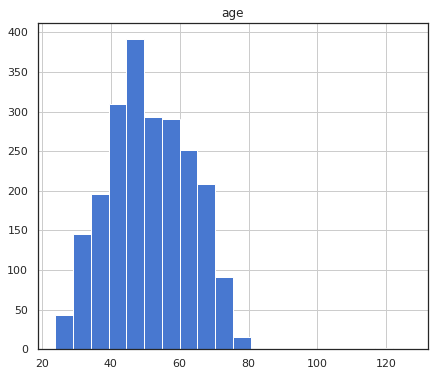

In [59]:
hist_plot(ifood, 'Age');

# Questão: Qual o nível de ensino dos clientes ?

### Graduation - 50,31%
### PhD        - 21,70%
### Master     - 16,52%
### 2n Cycle   - 9,06%
### Basic      - 2,41%

In [60]:
ifood.Education.value_counts(normalize=True)

Graduation    0.503125
PhD           0.216964
Master        0.165179
2n Cycle      0.090625
Basic         0.024107
Name: Education, dtype: float64

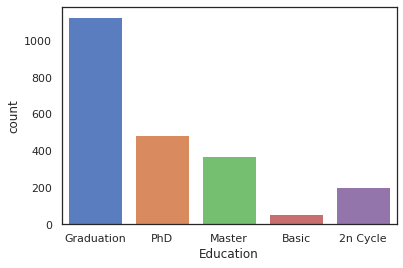

In [61]:
ax = sns.countplot(x="Education", data=ifood)

# Questão: Qual a distribuição dos estados civis ?

### As três maiores são:
### Married  - 846 ou 38,57%
### Together - 580 ou 25,90%
### Single   - 480 ou 21,43%

In [62]:
ifood.Marital_Status.value_counts()

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [63]:
ifood['Marital_Status'].value_counts('YOLO')

Married     0.385714
Together    0.258929
Single      0.214286
Divorced    0.103571
Widow       0.034375
Alone       0.001339
YOLO        0.000893
Absurd      0.000893
Name: Marital_Status, dtype: float64

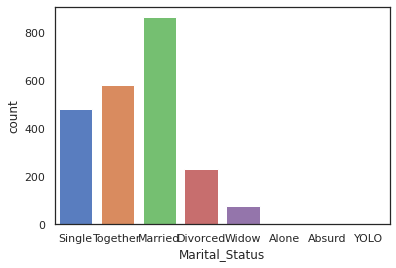

In [64]:
ax = sns.countplot(x="Marital_Status", data=ifood)

In [65]:
ifood['Marital_Status'].replace(to_replace=dict(Single='oneperson', Divorced='oneperson'), inplace=True)

In [66]:
ifood['Marital_Status'].replace(to_replace=dict(Married='couple', Together='couple'), inplace=True)

In [67]:
ifood

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age
0,5524,1957,Graduation,oneperson,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,63
1,2174,1954,Graduation,oneperson,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,66
2,4141,1965,Graduation,couple,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,55
3,6182,1984,Graduation,couple,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,36
4,5324,1981,PhD,couple,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,couple,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,53
2236,4001,1946,PhD,couple,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,74
2237,7270,1981,Graduation,oneperson,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,39
2238,8235,1956,Master,couple,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,64


# Questão: Qual a distribuição do income ?


### Maioria esta entre 50k e 100k

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43846bd828>]],
      dtype=object)

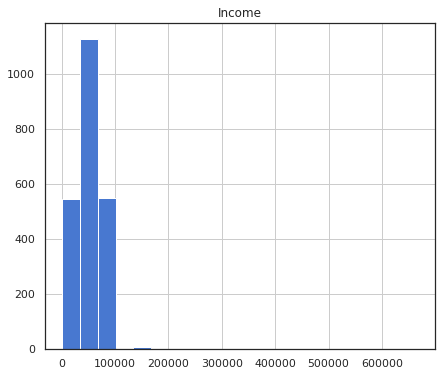

In [68]:
hist_plot(ifood,'Income',20)

### Uma técnica aplicada na segmentação de clientes é conhecida como RFM.
### Recency (R) - número de dias desde a última compra.
### Frequency (F) - número de compras efetuadas num periodo.
### Monetary (M)  - Volume total de vendas

### Recency
### O histograma mostra uma distribuição onde existe um consumo em periodos com 10 dias de intervalo.


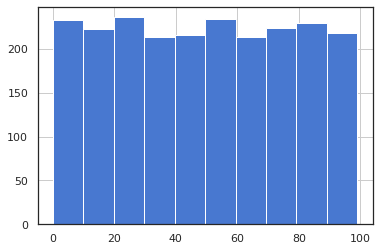

In [69]:
ifood.Recency.hist()

### Entre 20 e 30 dias existem 236 ocorrências, que seriam 236 clientes que efetuaram a última nesse intervalo de tempo.

In [70]:
ifood.Recency.value_counts(bins=10)

(19.8, 29.7]    236
(49.5, 59.4]    234
(-0.1, 9.9]     233
(79.2, 89.1]    229
(69.3, 79.2]    224
(9.9, 19.8]     223
(89.1, 99.0]    218
(39.6, 49.5]    216
(29.7, 39.6]    214
(59.4, 69.3]    213
Name: Recency, dtype: int64

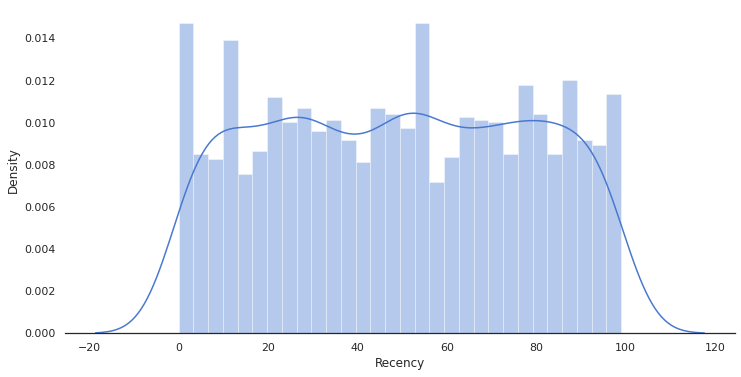

In [71]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(ifood['Recency'], bins=30)
plt.show()

### Clusters identificados no conjunto de dados Recency

In [133]:
from sklearn.cluster import KMeans 

def number_of_cluster(coluna):
  sse={}
  df_cluster = ifood[[coluna]]
  for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
  plt.figure(figsize=(10, 5))
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.title("Number of Cluster by Column\n"+coluna)
  plt.xlabel("Number of cluster")
  plt.show()

In [138]:
def create_cluster(ifood,coluna, nova_coluna):
  #building 3 clusters for Frequency and adding it to dataframe
  kmeans = KMeans(n_clusters=3)
  kmeans.fit(ifood[[coluna]])
  ifood[nova_coluna] = kmeans.predict(ifood[[coluna]])
  ifood = order_cluster(nova_coluna, coluna,ifood,False)

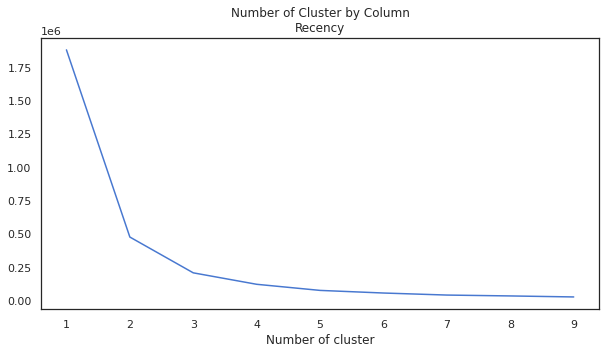

In [134]:
number_of_cluster('Recency')

### Criando o cluster a partir da coluna Recency

In [139]:
create_cluster(ifood,'Recency', 'RecencyCluster')

### Três clusters foram identificados.

In [94]:
ifood.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,730.0,82.935616,9.373515,67.0,75.0,83.0,91.0,99.0
1,747.0,49.884873,9.570684,33.0,42.0,50.0,57.0,66.0
2,763.0,15.986894,9.783072,0.0,8.0,16.0,25.0,32.0


### Frequency

### Quantidade de itens comprados pelo clientes efetuou no periodo.


In [75]:
ifood.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,RecencyCluster
0,5524,1957,Graduation,oneperson,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,63,1
1,5899,1950,PhD,couple,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0,70,1
2,387,1976,Basic,couple,7500.0,0,0,2012-11-13,59,6,16,11,11,1,16,1,2,0,3,8,0,0,0,0,0,0,3,11,0,44,1
3,8180,1952,Master,oneperson,59354.0,1,1,2013-11-15,53,233,2,53,3,5,14,3,6,1,5,6,0,0,0,0,0,0,3,11,0,68,1
4,9736,1980,Graduation,couple,41850.0,1,1,2012-12-24,51,53,5,19,2,13,4,3,3,0,3,8,0,0,0,0,0,0,3,11,0,40,1


### Filtrar as colunas que iniciam com os caracteres ID e as colunas que terminam em Purchases

In [76]:
frequency = ifood.loc[:,(ifood.columns.str.startswith("ID")) | (ifood.columns.str.endswith("Purchases"))]

In [77]:
frequency.head()

,ID,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
0,5524,3,8,10,4
1,5899,1,1,0,0
2,387,1,2,0,3
3,8180,3,6,1,5
4,9736,3,3,0,3


### A coluna Frequency será o valor total de compras efetuadas pelo cliente.

In [78]:
ifood['Frequency'] = frequency.loc[:,(frequency.columns.str.endswith("Purchases"))].sum(axis=1)

In [79]:
ifood.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,RecencyCluster,Frequency
0,5524,1957,Graduation,oneperson,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,63,1,25
1,5899,1950,PhD,couple,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0,70,1,2
2,387,1976,Basic,couple,7500.0,0,0,2012-11-13,59,6,16,11,11,1,16,1,2,0,3,8,0,0,0,0,0,0,3,11,0,44,1,6
3,8180,1952,Master,oneperson,59354.0,1,1,2013-11-15,53,233,2,53,3,5,14,3,6,1,5,6,0,0,0,0,0,0,3,11,0,68,1,15
4,9736,1980,Graduation,couple,41850.0,1,1,2012-12-24,51,53,5,19,2,13,4,3,3,0,3,8,0,0,0,0,0,0,3,11,0,40,1,9


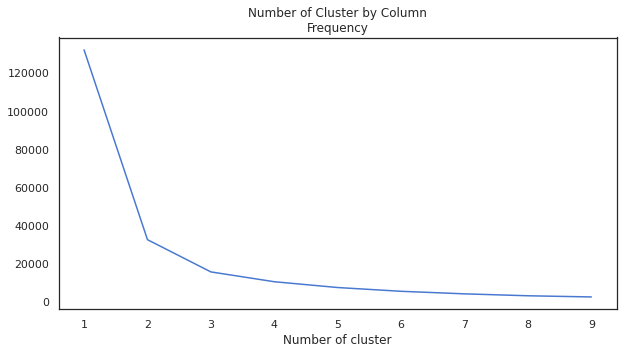

In [135]:
number_of_cluster('Frequency')

In [141]:
create_cluster(ifood, 'Frequency', 'FrequencyCluster')

In [142]:
ifood.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,512.0,25.312500,3.129933,22.0,23.0,25.0,27.0,44.0
1,969.0,7.301342,2.536105,0.0,5.0,7.0,9.0,12.0
2,759.0,17.465086,2.376452,13.0,16.0,17.0,19.0,21.0


### Monetary

### Filtrar as colunas que iniciam com os caracteres ID e Mnt, seguidos de zero ou mais caracteres

In [80]:
monetary = ifood.loc[:,(ifood.columns.str.startswith("ID")) | (ifood.columns.str.startswith("Mnt"))]

### Soma de todas compras (Dolar) efetuadas nos ultimos 2 anos

In [81]:
ifood['Monetary'] = monetary.loc[:,(monetary.columns.str.startswith("Mnt"))].sum(axis=1)

In [82]:
ifood.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age,RecencyCluster,Frequency,Monetary
0,5524,1957,Graduation,oneperson,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,63,1,25,1617
1,5899,1950,PhD,couple,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0,70,1,2,49
2,387,1976,Basic,couple,7500.0,0,0,2012-11-13,59,6,16,11,11,1,16,1,2,0,3,8,0,0,0,0,0,0,3,11,0,44,1,6,61
3,8180,1952,Master,oneperson,59354.0,1,1,2013-11-15,53,233,2,53,3,5,14,3,6,1,5,6,0,0,0,0,0,0,3,11,0,68,1,15,310
4,9736,1980,Graduation,couple,41850.0,1,1,2012-12-24,51,53,5,19,2,13,4,3,3,0,3,8,0,0,0,0,0,0,3,11,0,40,1,9,96


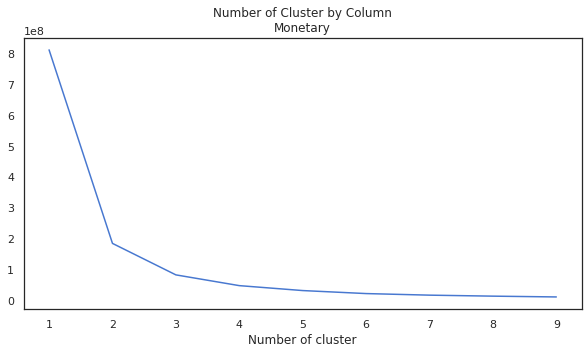

In [144]:
number_of_cluster("Monetary")

In [145]:
create_cluster(ifood, 'Monetary', 'MonetaryCluster')

In [146]:
# Details of each cluster
ifood.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,1271.0,152.561762,146.149376,5.0,44.0,81.0,241.0,535.0
1,607.0,920.140033,211.820161,541.0,734.5,929.0,1101.0,1295.0
2,362.0,1670.046961,271.940652,1298.0,1453.5,1616.5,1832.0,2525.0


### Traçando uma linha de regressão com os dados.
### E analisando se há correlação.
- Recency   x Monetary
- Frequency x Monetary

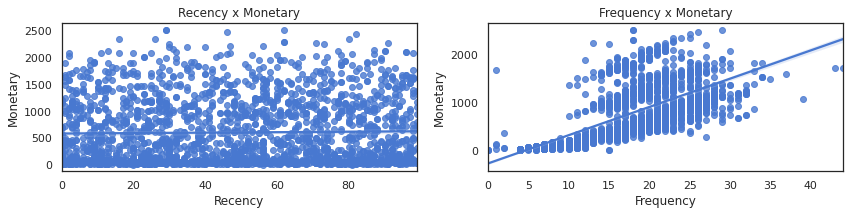

In [166]:
fig = plt.figure(figsize=(14,6))
f1 = fig.add_subplot(221); sns.regplot(x='Recency', y='Monetary', data=ifood)
plt.title("Recency x Monetary")
f1 = fig.add_subplot(222); sns.regplot(x='Frequency', y='Monetary', data=ifood)
plt.title("Frequency x Monetary")

plt.show()

### Correlação entre Recency e Monetary

In [174]:
ifood[['Recency', 'Monetary']].corr()

,Recency,Monetary
Recency,1.000000,0.020433
Monetary,0.020433,1.000000


### Correlação entre Frequency e Monetary

In [175]:
ifood[['Frequency', 'Monetary']].corr()

,Frequency,Monetary
Frequency,1.000000,0.753903
Monetary,0.753903,1.000000


### Recency x Monetary
#### A correlação entre a variável Recency, que identifica o número de dias desde a última compra e o valor Monetary, que representa o total de compras (Dolar) nos últimos 2 anos é nula. A visualização dos dados confirma essa informação.
### Frequency x Monetary
#### Apresenta uma correlação positiva, quanto maior o valor de Frequency( total de itens comprados no periodo) maior o total de compras no periodo.

### Plotando um gráfico 3D

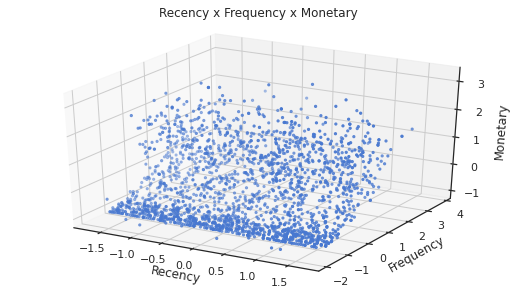

In [171]:
X = ifood[['Recency','Frequency','Monetary']].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

xs = X[:,0] # Recency
ys = X[:,1] # Frequency
zs = X[:,2] # Monetary

ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title("Recency x Frequency x Monetary\n")
plt.show()

### Criando um cluster a partir da coluna Age

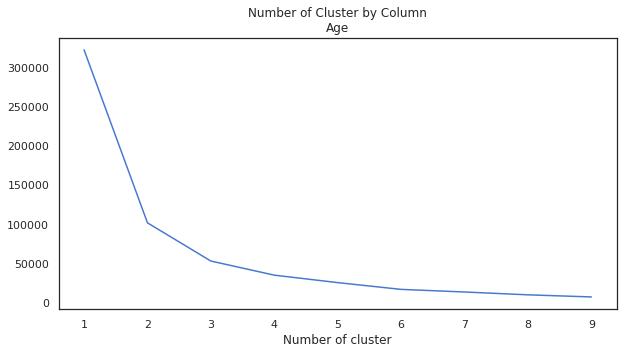

In [147]:
number_of_cluster("Age")

In [148]:
create_cluster(ifood, 'Age', 'AgeCluster')

In [149]:
ifood.groupby('AgeCluster')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
AgeCluster,,,,,,,,
0,606.0,37.927393,4.598024,25.0,35.0,39.0,42.0,44.0
1,699.0,66.517883,6.054969,59.0,62.0,66.0,70.0,128.0
2,935.0,50.732620,3.929676,45.0,47.0,50.0,54.0,58.0


### Criando um cluster a partir da coluna NumWebVisitsMonth
### Número de Visitas ao Site por Mês

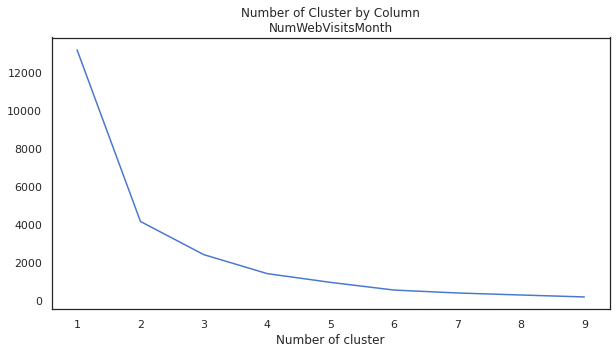

In [153]:
number_of_cluster("NumWebVisitsMonth")

In [154]:
create_cluster(ifood, 'NumWebVisitsMonth', 'NumWebVisitsMonthCluster')

In [155]:
ifood.groupby('NumWebVisitsMonthCluster')['NumWebVisitsMonth'].describe()

,count,mean,std,min,25%,50%,75%,max
NumWebVisitsMonthCluster,,,,,,,,
0,571.0,2.052539,0.838151,0.0,1.0,2.0,3.0,3.0
1,830.0,7.734940,1.243408,7.0,7.0,8.0,8.0,20.0
2,839.0,5.145411,0.802933,4.0,4.0,5.0,6.0,6.0


### Análise de Correlação.
- Age x Monetary
-  NumWebVisitsMonth x Monetary

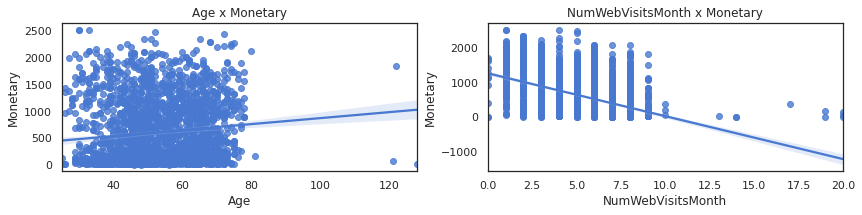

In [165]:
fig = plt.figure(figsize=(14,6))
f1 = fig.add_subplot(221); sns.regplot(x='Age', y='Monetary', data=ifood)
plt.title("Age x Monetary")
f1 = fig.add_subplot(222); sns.regplot(x='NumWebVisitsMonth', y='Monetary', data=ifood)
plt.title("NumWebVisitsMonth x Monetary")
plt.show()

### Correlação entre Age e Monetary

In [172]:
ifood[['Age', 'Monetary']].corr()

,Age,Monetary
Age,1.000000,0.111306
Monetary,0.111306,1.000000


### Correlação entre NumWebVisitsMonth e Monetary

In [173]:
ifood[['NumWebVisitsMonth', 'Monetary']].corr()

,NumWebVisitsMonth,Monetary
NumWebVisitsMonth,1.000000,-0.500218
Monetary,-0.500218,1.000000


### Age x Monetary
#### A correlação entre a variável Age, que identifica a idade do cliente e o valor Monetary é positiva. A visualização dos dados confirma essa informação.
### NumWebVisitsMonth x Monetary
#### Apresenta uma correlação negativa, quanto maior o número de visitas ao site mensalmente, menor o total de compras no periodo.

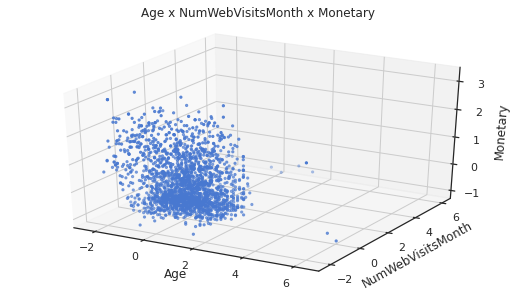

In [170]:
X = ifood[['Age','NumWebVisitsMonth','Monetary']].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111, projection='3d')

xs = X[:,0] # Age
ys = X[:,1] # NumWebVisitsMonth
zs = X[:,2] # Monetary

ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Age')
ax.set_ylabel('NumWebVisitsMonth')
ax.set_zlabel('Monetary')
plt.title("Age x NumWebVisitsMonth x Monetary\n")
plt.show()